This notebook makes use MITgcm and TPXO tidal amplitude and phase outputs.

The first part let us plot the tidal amplitude and phase maps, as well as the differences between the MITgcm and TPXO.

The second part is dedicated to the computation of the spatially averaged RMS.

In [11]:
import numpy as np
import xarray as xr
import os
from xmitgcm import open_mdsdataset
from os.path import expanduser,join,isdir
import sys
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py as ecco
from matplotlib.lines import Line2D

In [6]:
#This xarray will never be used (and the ETAN data contains only 50pts).
#The only goal is to later extract the XC and YC coordinates, and use them in the other xarrays.
data_dir ='/efs_ecco/hplombat/Hugo_tidal_maps/tides_5y_ETAN_sample'
grid_dir ='/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run'
ds_llc = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN_snapD'},
                         geometry="llc") #non-native grid


# Maps from MITgcm outputs

In [162]:
# The MITgcm outputs are stored in 13 tiles that we want to rearange and convert in a latitude-longitude frame.
# File path pattern
file_pattern = "/efs_ecco/hplombat/Hugo_tidal_maps/new_maps_mitgcm_1year/amp_comsts_{}.txt"
file_phase = "/efs_ecco/hplombat/Hugo_tidal_maps/new_maps_mitgcm_1year/pha_consts_{}.txt"
n_tiles = 13
amp_data, phase_data = [],[]
#List of the tidal constituents which have been fitted to the sea level map
constit_labels= ['M2', 'S2', 'N2', 'K2','K1', 'O1', 'P1', 'Q1', 'Mm', 'Mf', 'M4', 'Mn4', 'Ms4', '2N2']

#Choose the number of the tidal constituent to plot, following the order of constit_labels.
TIDAL_CONSTITUENT= 0

#AMPLITUDE 
#For a given constituent, open the 13 tiles and stack them in an array with shape (tile,i,j) 
for tile in range(n_tiles):
    filename = file_pattern.format(tile)
    # Load the 90x90 array
    data = np.loadtxt(filename)
    nx, ny = 90, 90 
    n_constituents = data.shape[0]
    amp_3d = data.reshape(n_constituents, nx, ny)
    amp_data.append(amp_3d[TIDAL_CONSTITUENT,:,:])
    

#PHASE 
for tile in range(n_tiles):
    filename = file_phase.format(tile)
    # Load the 90x90 array
    pha_data = np.loadtxt(filename)
    nx, ny = 90, 90 
    # Reshape to 3D
    n_constituents = pha_data.shape[0]
    pha_3d = pha_data.reshape(n_constituents, nx, ny)
    phase_data.append(pha_3d[TIDAL_CONSTITUENT,:,:])


# To compare MITgcm maps with  TPXO, we need to convert them from (tile,i,j) to (lat,lon) coordinates.

#Import the lat and long coordinates from the original xarray
XC = ds_llc['XC'].data
YC = ds_llc['YC'].data

# Create xarrays for amplitude and phase.
ds_amp = xr.DataArray(
    amp_data,
    dims=["tile", "i", "j"],
    coords={
        "tile": np.arange(n_tiles),
        "i": np.arange(90),
        "j": np.arange(90),
        "XC": (["tile", "i", "j"], XC),
        "YC": (["tile", "i", "j"], YC)
    },
    name="amplitude"
)
ds_pha = xr.DataArray(
    pha_array,
    dims=["tile", "i", "j"],
    coords={
        "tile": np.arange(n_tiles),
        "i": np.arange(90),
        "j": np.arange(90),
        "XC": (["tile", "i", "j"], XC),
        "YC": (["tile", "i", "j"], YC)
    },
    name="phase"
)
#Interpolate the previous xarrays from XC,YC to the same 1deg (lat,long) coordinates than TPXO data.
new_grid_delta_lat = 1 
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 91

new_grid_min_lon = -180
new_grid_max_lon = 181
ds_lat_lon_amp = ecco.resample_to_latlon(ds_amp.XC, 
                                ds_amp.YC, 
                                ds_amp.where(ds_pha!=0),
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.nan, 
                                mapping_method = 'nearest_neighbor',
                                    )

ds_lat_lon_phase = ecco.resample_to_latlon(ds_pha.XC, 
                                ds_pha.YC, 
                                ds_pha.where(ds_pha!=0),
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.nan, 
                                mapping_method = 'nearest_neighbor',
                                    )

### Amplitude map

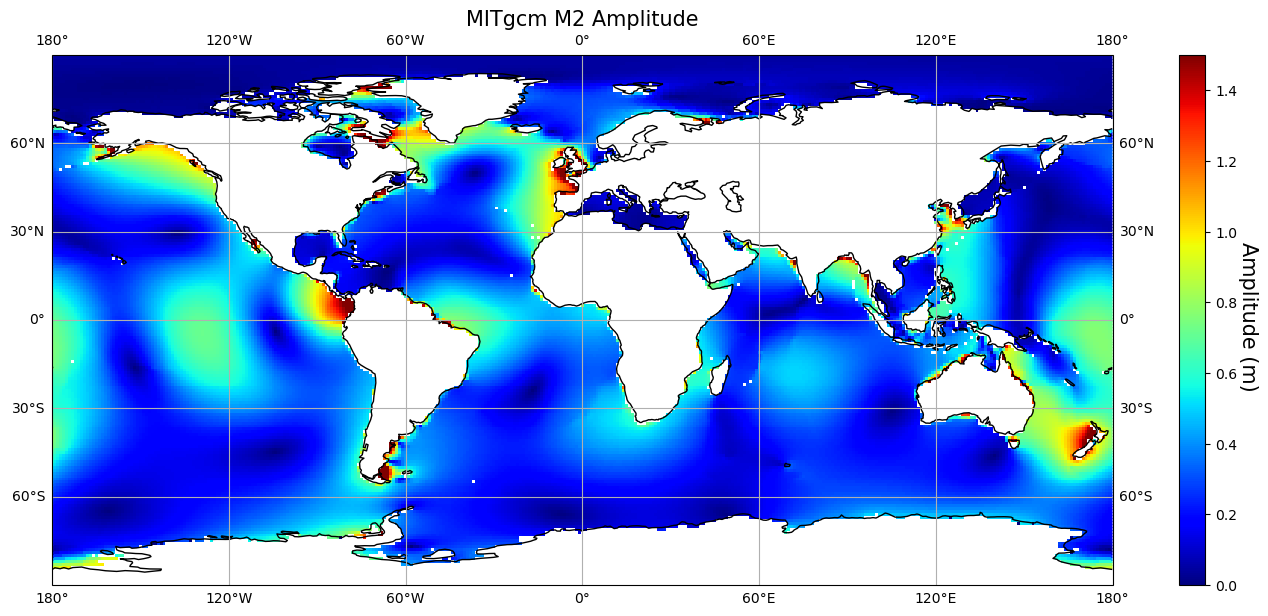

In [163]:
longitude = np.arange(new_grid_min_lon,new_grid_max_lon)
latitude = np.arange(new_grid_min_lat,new_grid_max_lat)


fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

pcm = ax.pcolormesh(longitude, latitude,ds_lat_lon_amp[4],
                    cmap='jet', shading='auto',
                       vmax = 1.5,
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()
ax.gridlines(draw_labels=True)
#ax.contour(longitude, latitude, ds_lat_lon_phase[4], levels=np.arange(0,360,45), colors='k')

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'Amplitude (m) ',  rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm '+ constit_labels[TIDAL_CONSTITUENT]+' Amplitude',fontsize=15)
plt.tight_layout()

plt.show()


### Phase map

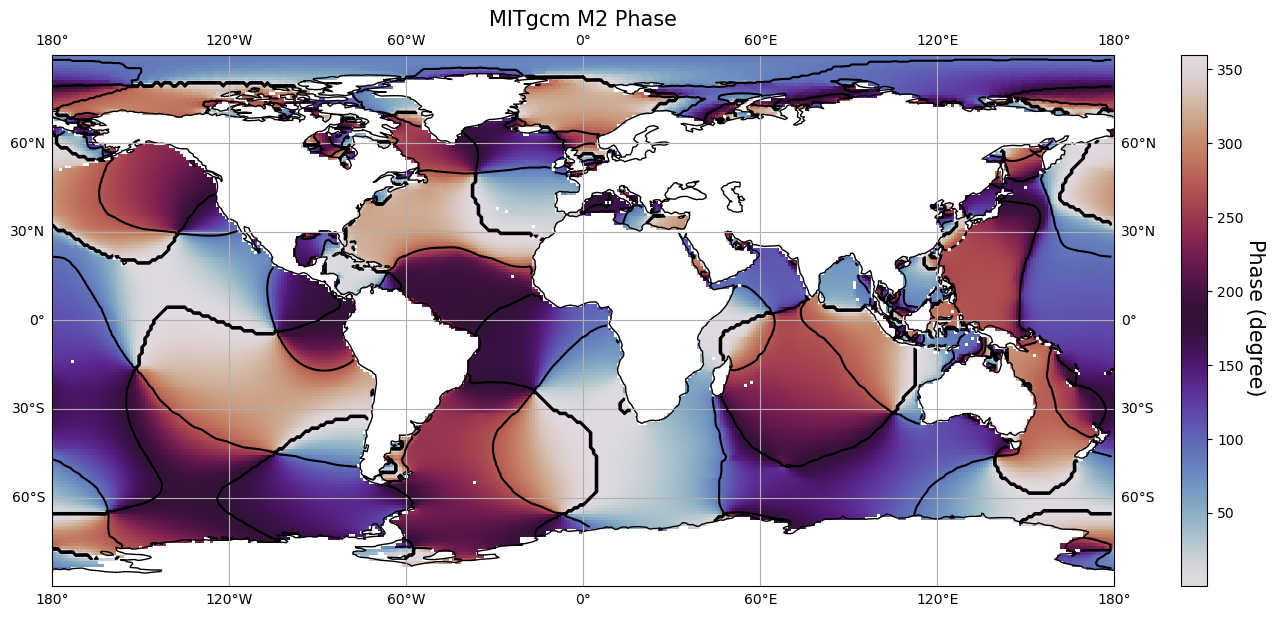

In [164]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# The 'twilight' colorbar highlights the cyclical values of the phase.
pcm = ax.pcolormesh(longitude, latitude,ds_lat_lon_phase[4],#ds_lat_lon[4] ,#- amp_map,
                    cmap='twilight', shading='auto', 
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()

ax.gridlines(draw_labels=True)

ax.contour(longitude, latitude, ds_lat_lon_phase[4], levels = np.arange(0, 361, 90), colors='k')#,width=0.2)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'Phase (degree) ',  rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm '+ constit_labels[TIDAL_CONSTITUENT]+' Phase',fontsize=15)
plt.tight_layout()

plt.show()

# Maps from TPXO outputs

### Amplitude Map

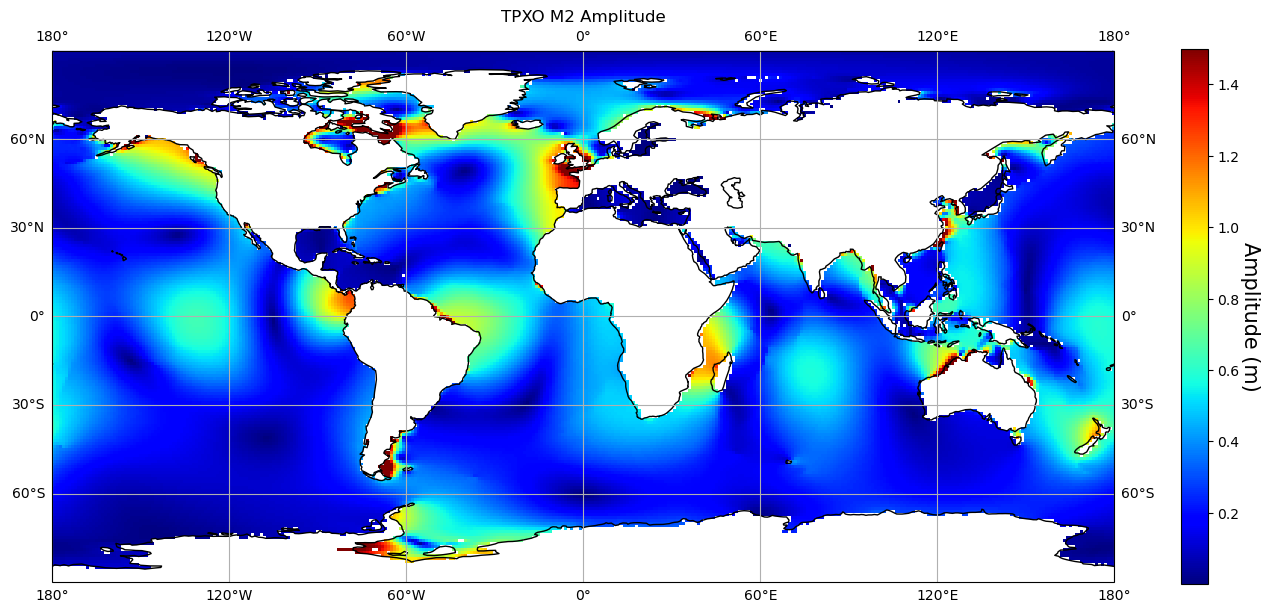

In [166]:
constituents = ['m2', 's2', 'n2', 'k2','k1', 'o1', 'p1', 'q1', 'mm', 'mf', 'm4', 'mn4', 'ms4', '2n2']
amp_map= np.loadtxt('/efs_ecco/hplombat/Hugo_tidal_maps/maps_tpxo/ampli_ll_txpo_'+constituents[TIDAL_CONSTITUENT]+'.txt')
ph_map= np.loadtxt('/efs_ecco/hplombat/Hugo_tidal_maps/maps_tpxo/ph_ll_txpo_'+constituents[TIDAL_CONSTITUENT]+'.txt')

#The land cells in TPXO amplitude and phase maps have a 1e20 value, we replace them with nans
ph_map[ph_map>1e19] = np.nan 
amp_map[amp_map>1e19] = np.nan

# TXPO maps are defined with longitude (0.360), we redefine them to be between (-180,180)
lon = np.arange(0,361)
# Convert to -180 to 180
lon_mod = ((lon + 180) % 360) - 180

sort_idx = np.argsort(lon_mod)
lon_sorted = lon_mod[sort_idx]
amp_sorted = amp_map[:, sort_idx] if amp_map.ndim == 2 else amp_map[sort_idx]




fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

#longitude +180 to shift from (0,360) to (-180,180)

pcm = ax.pcolormesh(longitude, latitude, amp_sorted,
                    cmap='jet', shading='auto',
                    transform=ccrs.PlateCarree(),vmax = 1.5)

# Add coastlines and features
ax.coastlines()

ax.gridlines(draw_labels=True)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label('Amplitude (m)',rotation = 270,labelpad = 15,fontsize=15)

plt.title('TPXO ' + constit_labels[TIDAL_CONSTITUENT]+' Amplitude')
plt.tight_layout()
#plt.savefig('./Plots/ampli_M2_TPXO.pdf',bbox_inches='tight')
plt.show()

# Phase map

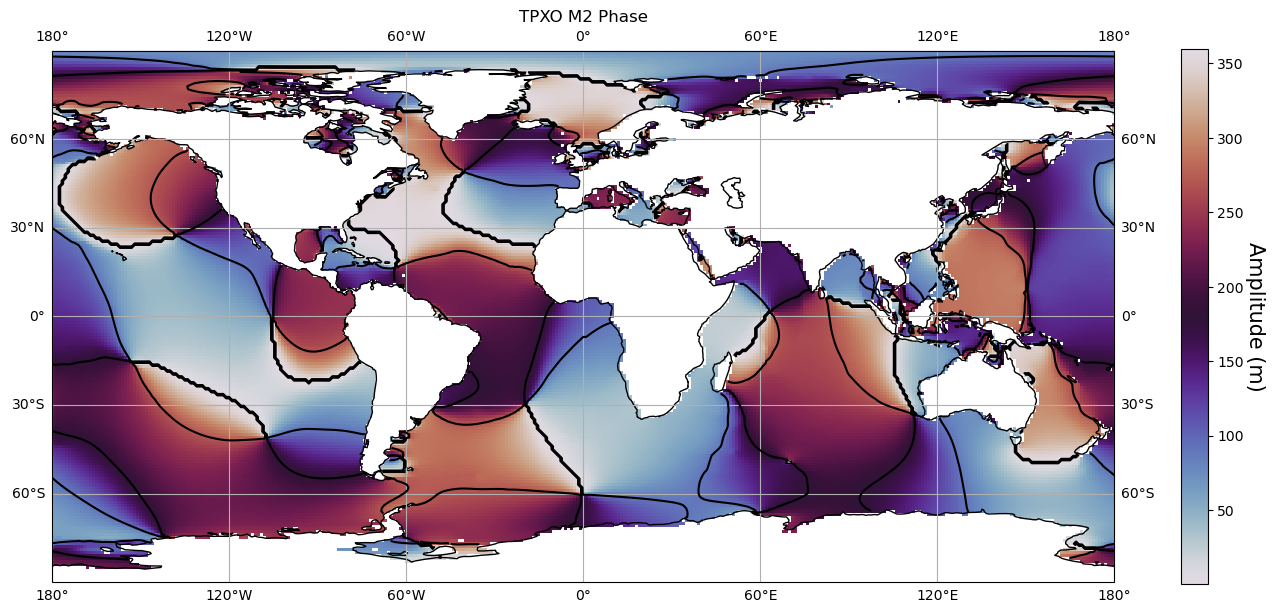

In [167]:
# TXPO maps are defined with longitude (-180,180), we redefine them to be between (0.360)
ph_sorted = ph_map[:, sort_idx] if ph_map.ndim == 2 else ph_map[sort_idx]


fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

#longitude +180 to shift from (0,360) to (-180,180)
pcm = ax.pcolormesh(longitude, latitude, ph_sorted,
                    cmap='twilight', shading='auto',
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()

ax.gridlines(draw_labels=True)
ax.contour(longitude, latitude, ph_sorted, levels = np.arange(0, 361, 90), colors='k')#,width=0.2)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label('Amplitude (m)',rotation = 270,labelpad = 15,fontsize=15)

plt.title('TPXO ' + constit_labels[TIDAL_CONSTITUENT]+' Phase')
plt.tight_layout()
#plt.savefig('./Plots/ampli_M2_TPXO.pdf',bbox_inches='tight')
plt.show()

# Map differences

# Amplitude

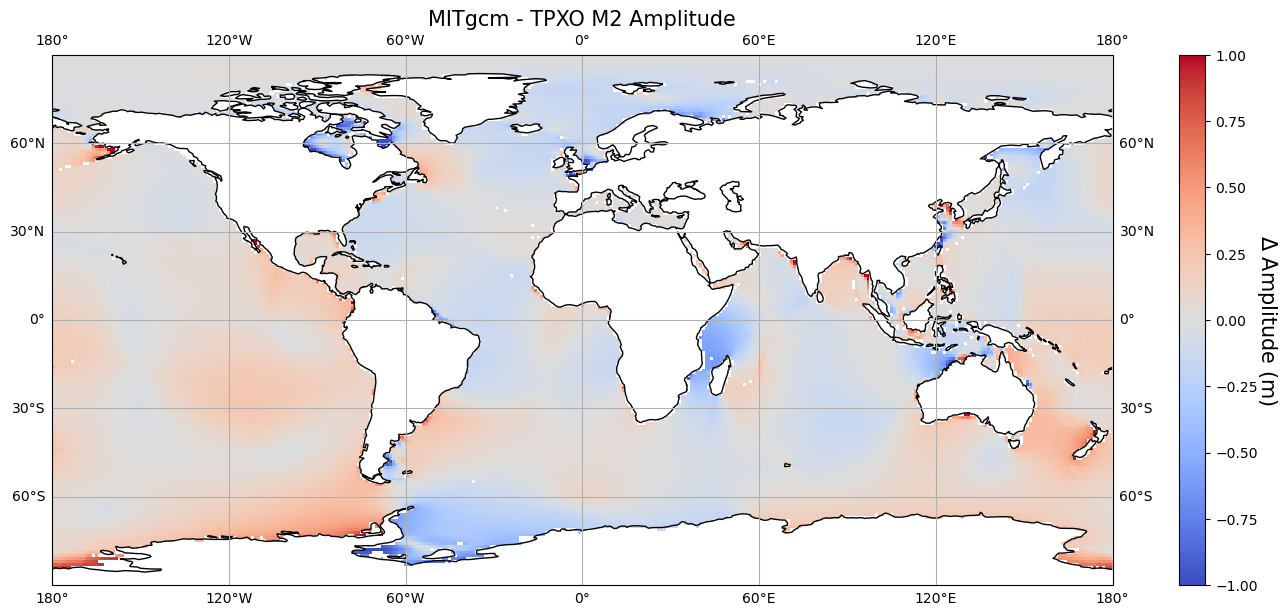

In [206]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot amplitude using pcolormesh
pcm = ax.pcolormesh(longitude, latitude,ds_lat_lon_amp[4] - amp_sorted,#ds_lat_lon[4] ,#- amp_map,
                    cmap='coolwarm', shading='auto',
                    vmax = 1., vmin = -1.,
                    transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True)

# Add colorbar
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'$\Delta$ Amplitude (m)', rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm - TPXO '+constit_labels[TIDAL_CONSTITUENT]+' Amplitude',fontsize=15)
plt.tight_layout()


plt.show()

### Phase 

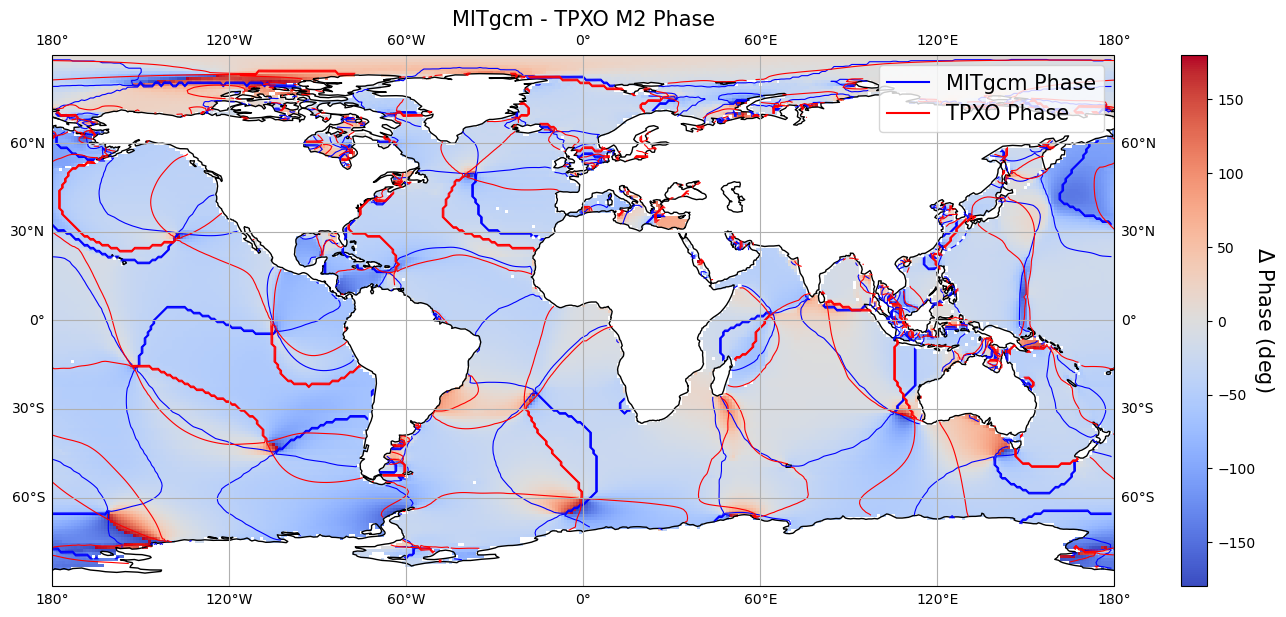

In [170]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Modulate the phase difference between 0 (in phase) and 180 (out of phase)
phase_diff = (ds_lat_lon_phase[4] - ph_sorted + 180) % 360 - 180


pcm = ax.pcolormesh(longitude, latitude, phase_diff, #ds_lat_lon_phase[4] - ph_sorted,#ds_lat_lon[4] ,#- amp_map,
                    cmap='coolwarm', shading='auto',
                    transform=ccrs.PlateCarree())

ax.contour(longitude, latitude, ds_lat_lon_phase[4], levels=np.arange(0,361,90), colors='blue',linewidths = 0.8)
ax.contour(longitude, latitude, ph_sorted, levels=np.arange(0,361,90), colors='red',linewidths = 0.8)#,width=0.2)

ax.coastlines()
ax.gridlines(draw_labels=True)

legend_lines = [
    Line2D([0], [0], color='blue', label='MITgcm Phase'),
    Line2D([0], [0], color='red', label='TPXO Phase')
]


ax.legend(handles=legend_lines, loc='upper right',fontsize =15) 

cbar = plt.colorbar(pcm, orientation='vertical', pad=0.05)
cbar.set_label(r'$\Delta$ Phase (deg) ',  rotation = 270, fontsize =15,labelpad= 15)

plt.title('MITgcm - TPXO '+constit_labels[TIDAL_CONSTITUENT]+' Phase',fontsize=15)
plt.tight_layout()
plt.show()


# Computation of spatially averaged Root Mean Square of the tidal amplitude components

### TPXO

In [242]:
#The RMS of a sine wave is  A/sqrt(2).
#We want the spatial average of the RMS for each tidal component.
#The grid cells are of unequal physical size, so we weight their respective contribution
#Works with this definition of latitude, unsure why...
#latt = np.arange(0,181)

# Compute area weights using latitude
cos_lat = np.cos(latitude)
weight_map = np.tile(cos_lat[:, np.newaxis], (1, len(longitude))) 

# Apply weights
amp_weighted = amp_sorted * weight_map

# Sum over all spatial points
amp_sum = np.nansum(amp_weighted)  

# Total weight (for normalization)
total_weight = np.nansum(weight_map)


#Normalize
amp_sum /=  total_weight

# Compute RMS of the total signal
rms_total = 100*np.abs(Z_sum) / np.sqrt(2) #multiply by 1e2 to convert from meters to centimeters.

print("Total RMS of TPXO tidal signal from component "+constit_labels[TIDAL_CONSTITUENT]+": "+ str(round(rms_total,4))+" centimeters")


Total RMS of TPXO tidal signal from component M2: 24.6232 centimeters


# MITgcm

In [241]:

# TO CLEAN: I had to do again the resample with different def of latitude and longitude.
# Need to clean this to be sure we are fully consistent with TPXO RMS computation

la = np.arange(0,181)
minlat=0
maxlat=181
minlong=0
maxlong = 361


ds_ll_amp= ecco.resample_to_latlon(ds_amp.XC, 
                                ds_amp.YC, 
                                ds_amp.where(ds_amp!=0),
                                minlat,maxlat, new_grid_delta_lat,
                                minlong,maxlong, new_grid_delta_lon,
                                fill_value = np.nan, 
                                mapping_method = 'nearest_neighbor',
                                    )



# Compute area weights using latitude
cos_lat = np.cos(la)
weight_map = np.tile(cos_lat[:, np.newaxis], (1, len(longitude))) 

amp_weighted = ds_ll_amp[4]*weight_map

# Sum over all spatial points
amp_sum = np.nansum(amp_weighted) 

# Total weight 
total_weight = np.nansum(weight_map)

# Normalize
amp_sum /= total_weight

# Compute RMS of the total signal
rms_total = 100*np.abs(amp_sum) / np.sqrt(2)#multiply by 1e2 to convert from meters to centimeters.

print("Total RMS of MITgcm tidal signal from component "+constit_labels[TIDAL_CONSTITUENT]+": "+ str(round(rms_total,4))+" centimeters")


Total RMS of MITgcm tidal signal from component M2: 19.9143 centimeters
